# Odhad CDPF

## Cíl analýzy

## Data a metoda

NAMA_10_A10

In [201]:
import eurostat
import pandas
import statsmodels.formula.api as smf
import numpy

LOCATIONS = ["CZ", "DE", "AT", "EU27_2020", "ES"]
BASE_LOCATION = "CZ"
START_YEAR = 1980
END_YEAR = 2020

### Hrubá přidaná hodnota (Gross Value Added)

In [202]:
data_1_es = eurostat.get_data_df('nama_10_a10')

In [230]:
data_1 = data_1_es
# Value added, gross
data_1 = data_1[data_1["na_item"] == "B1G"]
# Total, all NACE activities
data_1 = data_1[data_1["nace_r2"] == "TOTAL"]
# Current prices, million euro
data_1 = data_1[data_1["unit"].isin(["CP_MNAC", "PD10_NAC"])]
data_1 = pandas.melt(data_1, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_1 = data_1.pivot(index=["na_item", "geo\\time", "year"], columns="unit", values="value")
data_1 = data_1.reset_index()
data_1 = data_1.rename({"CP_MNAC": "gross_value_added", "PD10_NAC": "gross_value_added_deflator"}, axis=1)
data_1["gross_value_added"] = data_1["gross_value_added"] * data_1["gross_value_added_deflator"]
data_1 = data_1.dropna()
data_1.tail()

unit,na_item,geo\time,year,gross_value_added,gross_value_added_deflator
1840,B1G,XK,2016,547200.4080,112.890
1841,B1G,XK,2017,577304.7840,113.064
1842,B1G,XK,2018,617278.2520,114.740
1843,B1G,XK,2019,661185.7636,116.026
1844,B1G,XK,2020,660210.0975,118.095


In [231]:
data_1 = data_1.sort_values(["geo\\time", "year"])
data_1["ln_gross_value_added"] = numpy.log(data_1["gross_value_added"])
data_1["ln_gross_value_added_t_minus_1"] = data_1.groupby("geo\\time")["ln_gross_value_added"].shift(1)
data_1["ln_gross_value_added_diff"] = (data_1["ln_gross_value_added"] - data_1["ln_gross_value_added_t_minus_1"]) / data_1["ln_gross_value_added"]
data_1 = data_1[["geo\\time", "year", "ln_gross_value_added", "ln_gross_value_added_diff"]]
data_1.tail()

unit,geo\time,year,ln_gross_value_added,ln_gross_value_added_diff
1840,XK,2016,13.212570,0.004012
1841,XK,2017,13.266126,0.004037
1842,XK,2018,13.333075,0.005021
1843,XK,2019,13.401790,0.005127
1844,XK,2020,13.400313,-0.000110


In [205]:
data_2_es = eurostat.get_data_df('nama_10_a10_e')

In [222]:
# data_2 = data_2_es
# # Total employment domestic concept
# data_2 = data_2[data_2["na_item"] == "EMP_DC"]
# # Total, all NACE activities
# data_2 = data_2[data_2["nace_r2"] == "TOTAL"]
# # Thousands hours worked
# data_2 = data_2[data_2["unit"] == "THS_HW"]
# data_2 = pandas.melt(data_2, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
#                     value_name="thousands_hours_worked", var_name="year")
# data_2 = data_2.sort_values(["geo\\time", "year"])
# data_2 = data_2.dropna()
# data_2["ln_thousands_hours_worked"] = numpy.log(data_2["thousands_hours_worked"])
# data_2["ln_thousands_hours_worked_t_minus_1"] = data_2.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
# data_2["ln_thousands_hours_worked_diff"] = (data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]) / data_2["ln_thousands_hours_worked"]
# data_2 = data_2[["geo\\time", "year", "ln_thousands_hours_worked", "ln_thousands_hours_worked_diff"]]
# data_2.head()

data_2_es = eurostat.get_data_df('nama_10_a10')
data_2 = data_2_es
# Total employment domestic concept
data_2 = data_2[data_2["na_item"] == "D11"]
# Total, all NACE activities
data_2 = data_2[data_2["nace_r2"] == "TOTAL"]
# Thousands hours worked
data_2 = data_2[data_2["unit"] == "CP_MNAC"]
data_2 = pandas.melt(data_2, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="thousands_hours_worked", var_name="year")
data_2 = data_2.sort_values(["geo\\time", "year"])
data_2 = data_2.dropna()
data_2["ln_thousands_hours_worked"] = numpy.log(data_2["thousands_hours_worked"])
data_2["ln_thousands_hours_worked_t_minus_1"] = data_2.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
data_2["ln_thousands_hours_worked_diff"] = (data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]) / data_2["ln_thousands_hours_worked"]
data_2 = data_2[["geo\\time", "year", "ln_thousands_hours_worked", "ln_thousands_hours_worked_diff"]]
data_2.head()

,geo\time,year,ln_thousands_hours_worked,ln_thousands_hours_worked_diff
630,AT,1995,11.213549,NaN
672,AT,1996,11.220449,0.000615
714,AT,1997,11.236202,0.001402
756,AT,1998,11.276471,0.003571
798,AT,1999,11.313000,0.003229


In [207]:
data_3_es = eurostat.get_data_df('nama_10_nfa_bs')

In [223]:
data_3 = data_3_es
data_3 = eurostat.get_data_df('nama_10_nfa_bs')
# Total fixed assets (net)
data_3 = data_3[data_3["asset10"] == "N11N"]
# Total, all activities
data_3 = data_3[data_3["sector"] == "S1"]
# Current fixed prices, millions of national currency
data_3 = data_3[data_3["unit"] == "CP_MNAC"]
data_3 = pandas.melt(data_3, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="total_fixed_assets", var_name="year")
data_3 = data_3.sort_values(["geo\\time", "year"])
data_3 = data_3.dropna()

In [209]:
data_4_es = eurostat.get_data_df('nama_10_nfa_fl')

In [224]:
data_4 = data_4_es
#
data_4 = data_4[data_4["asset10"] == "N11G"]
#
data_4 = data_4[data_4["nace_r2"] == "TOTAL"]
#
data_4 = data_4[data_4["unit"] == "PD10_NAC"]
data_4 = pandas.melt(data_4, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="capital_stock_deflator", var_name="year")
data_4 = data_4.sort_values(["geo\\time", "year"])
data_4 = data_4.dropna()

In [225]:
data_3 = data_3.merge(data_4, on=["geo\\time", "year"])
data_3["total_fixed_assets"] = data_3["total_fixed_assets"] * data_3["capital_stock_deflator"]
data_3.head()

,unit_x,asset10_x,geo\time,year,total_fixed_assets,unit_y,asset10_y,capital_stock_deflator
0,CP_MNAC,N11N,AT,1995,5.044339e+07,PD10_NAC,N11G,79.960
1,CP_MNAC,N11N,AT,1996,5.320327e+07,PD10_NAC,N11G,80.723
2,CP_MNAC,N11N,AT,1997,5.602843e+07,PD10_NAC,N11G,81.648
3,CP_MNAC,N11N,AT,1998,5.848546e+07,PD10_NAC,N11G,82.293
4,CP_MNAC,N11N,AT,1999,6.098174e+07,PD10_NAC,N11G,82.710


In [226]:
data_3["ln_total_fixed_assets"] = numpy.log(data_3["total_fixed_assets"])
data_3["ln_total_fixed_assets_t_minus_1"] = data_3.groupby("geo\\time")["ln_total_fixed_assets"].shift(1)
data_3["ln_total_fixed_assets_diff"] = (data_3["ln_total_fixed_assets"] - data_3["ln_total_fixed_assets_t_minus_1"]) / data_3["ln_total_fixed_assets"]
data_3 = data_3[["geo\\time", "year", "ln_total_fixed_assets", "ln_total_fixed_assets_diff"]]

In [233]:
data = pandas.merge(data_1, data_2, on=["geo\\time", "year"])
data = pandas.merge(data, data_3, on=["geo\\time", "year"])
data.head()

,geo\time,year,ln_gross_value_added,ln_gross_value_added_diff,ln_thousands_hours_worked,ln_thousands_hours_worked_diff,ln_total_fixed_assets,ln_total_fixed_assets_diff
0,AT,1995,16.381579,NaN,11.213549,NaN,17.736362,NaN
1,AT,1996,16.417358,0.002179,11.220449,0.000615,17.789630,0.002994
2,AT,1997,16.455536,0.002320,11.236202,0.001402,17.841370,0.002900
3,AT,1998,16.498469,0.002602,11.276471,0.003571,17.884289,0.002400
4,AT,1999,16.535190,0.002221,11.313000,0.003229,17.926085,0.002332


<AxesSubplot:xlabel='ln_total_fixed_assets_diff', ylabel='ln_gross_value_added_diff'>

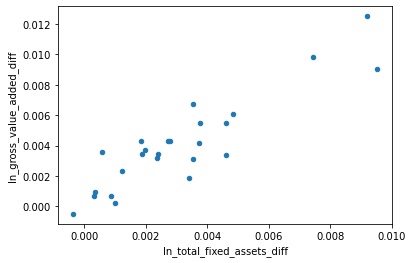

In [234]:
data_plot = data[data["geo\\time"] == "CZ"]
data_plot.plot(x="ln_total_fixed_assets_diff", y="ln_gross_value_added_diff", kind="scatter")

<AxesSubplot:xlabel='ln_thousands_hours_worked_diff', ylabel='ln_gross_value_added_diff'>

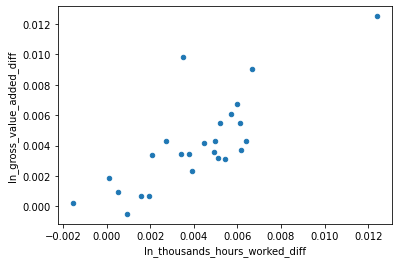

In [235]:
data_plot = data[data["geo\\time"] == "CZ"]
data_plot.plot(x="ln_thousands_hours_worked_diff", y="ln_gross_value_added_diff", kind="scatter")

In [236]:
data_plot = data[data["geo\\time"] == "CZ"]

data_plot = data_plot[data_plot["year"] > 2000]

mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_thousands_hours_worked_diff + ln_total_fixed_assets_diff", data=data_plot)
res = mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ln_gross_value_added_diff   R-squared:                       0.831
Model:                                   OLS   Adj. R-squared:                  0.811
Method:                        Least Squares   F-statistic:                     41.80
Date:                       Thu, 09 Dec 2021   Prob (F-statistic):           2.73e-07
Time:                               22:15:08   Log-Likelihood:                 113.90
No. Observations:                         20   AIC:                            -221.8
Df Residuals:                             17   BIC:                            -218.8
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       3.021e-05      0.000      0.076      0.940      -0.001       0.001
ln_thousands_hours_worked_diff     0.4561      0.107      4.258      0.001       0.230       0.682
ln_total_fixed_assets_diff         0.6736      0.170      3.951      0.001       0.314       1.033
==============================================================================
Omnibus:                        1.464   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                0.458
Skew:                           0.336   Prob(JB):                        0.795
Kurtosis:                       3.312   Cond. No.                         938.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""